## Modeling Moro Cojo Slough water levels

In [1]:
import pandas as pd
import numpy as np
from physoce import tseries as ts
from scipy import stats
from matplotlib import pyplot as plt
from scipy.integrate import odeint

### Read in the flow data ###
col_names =  ['Sample','year','month','day','hour','minute','second','Stage','Area','Vx','VMean','Flow','Total Volume']

flowfile1 = "Data_2016/ADCPData/ADCP_deployment_6_13_6_16/MC006005.txt"
flowdf1 = pd.read_table(flowfile1,header=18,delim_whitespace=True,usecols=range(13),names=col_names)

flowfile2 = "Data_2016/ADCPData/ADCPdeplyment_6_20_7_7/MC006009.txt"
flowdf2 = pd.read_table(flowfile2,header=18,delim_whitespace=True,usecols=range(13),names=col_names)

flowdf1 = flowdf1.set_index(pd.DatetimeIndex(pd.to_datetime(flowdf1[['year','month','day','hour','minute','second']])))
flowdf2 = flowdf2.set_index(pd.DatetimeIndex(pd.to_datetime(flowdf2[['year','month','day','hour','minute','second']])))

# combine data sets
flowdf = flowdf1.append(flowdf2)
flowdf = flowdf.resample('15min').mean()

### Read in the water level data ###

# This is referenced to MLLW, time zone: LST/LDT

wlfile1 = 'Data_2016/WaterLevelData/wlJune.txt'
wlfile2 = 'Data_2016/WaterLevelData/wlJuly.txt'
wldf1 = pd.read_table(wlfile1)
wldf2 = pd.read_table(wlfile2)
wldf1 = wldf1.set_index(pd.to_datetime(wldf1['Date Time'] + ' ' + wldf1['Date Time.1']))
wldf2 = wldf2.set_index(pd.to_datetime(wldf2['Date Time'] + ' ' + wldf2['Date Time.1']))

wldf = wldf1.append(wldf2)
wldf = wldf.resample('15min').mean()

df = pd.concat([wldf, flowdf], axis=1)

d = dict()
d['dtime'] = np.array(df.index)
d['h'] = np.array(df['Stage'])
d['hocn'] = np.array(df[' Water Level'])
d['Q'] = np.array(df['Flow'])*2 # does Q need to be doubled?

dt = np.timedelta64(d['dtime'][1]-d['dtime'][0],'s')
d['dt'] = dt/np.timedelta64(1,'s')

# despike ADCP stage data
hdiff = np.diff(d['h'])
hdiffz = (hdiff-np.nanmean(hdiff))/np.nanstd(hdiff)

ihspike, = np.where((np.abs(hdiffz[:-1])>3.))
ihspike = ihspike+1
d['h'][ihspike] = np.nan

# water level time derivative
d['dhdt'] = np.nan*d['h']
d['dhdt'][1:-1] = 0.5*(d['h'][2:]-d['h'][:-2])/d['dt']

# running standard deviation (2-day)
winlen = int(2*86400/d['dt'])
d['hocn_std'] = np.array(df[' Water Level'].rolling(window=winlen).std())

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in greater


### Visual comparison of Moro Cojo and Monterey Bay water levels

Summer 2016 - using stage data from the ADCP for water level. 

(array([736116., 736123., 736130., 736137., 736144., 736146., 736153.,
        736160., 736167., 736174., 736177.]),
 <a list of 11 Text xticklabel objects>)

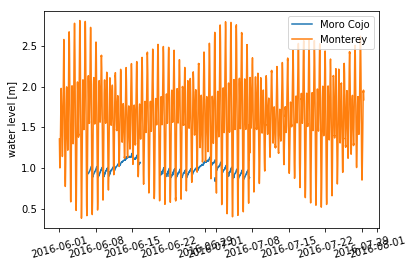

In [2]:
plt.close('all')
plt.plot(d['dtime'],d['h'])
plt.plot(d['dtime'],d['hocn']+0.75)
plt.ylabel('water level [m]')
plt.legend(['Moro Cojo','Monterey'])
plt.xticks(rotation=15)

Text(0.5, 1.0, 'Monterey water level \n 2 day running standard deviation')

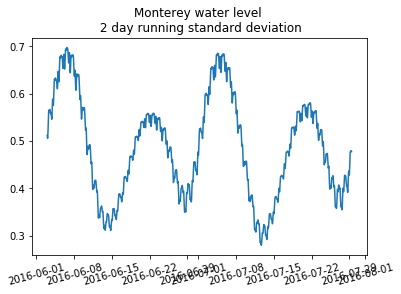

In [3]:
plt.figure()
plt.plot(d['dtime'],d['hocn_std'])
plt.xticks(rotation=15)
plt.title('Monterey water level \n 2 day running standard deviation')

### Relationship between flow and water level difference

Note: an ad-hoc adjustment of 0.75 m is used to account for the unknown level of the ADCP with respect to a vertical datum. The adjustment is made so that the flow through the culvert is zero when the difference between the ocean and Moro Cojo water levels is zero.

Text(0, 0.5, 'discharge')

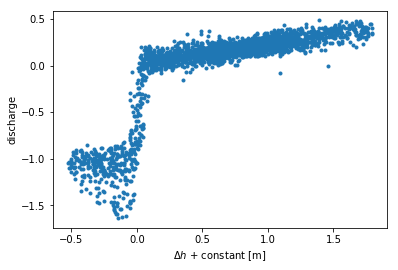

In [4]:
plt.figure()
plt.plot(d['hocn']-d['h']+0.75,d['Q'],'.')
plt.xlabel('$\Delta h$ + constant [m]')
plt.ylabel('discharge')

### Discharge

Text(0, 0.5, 'Q [m$^3$/s]')

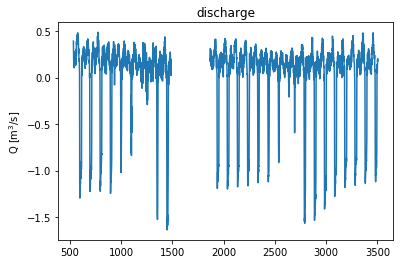

In [5]:
dnew = dict()
dnew['DateTime_LDT'] = d['dtime']
dnew['Q'] = d['Q']
dnew['Monterey_WaterLevel_NAVD'] = d['hocn']+0.043

dfnew = pd.DataFrame.from_dict(dnew)
dfnew.to_csv('MontereyWaterLevel_MoroCojoQ.csv')

plt.figure()
plt.plot(dfnew['Q'])
plt.title('discharge')
plt.ylabel('Q [m$^3$/s]')

### Relationships between flow and water level for summer 2016

water level > 0.44 m:
slope =  0.215
intercept =  -0.046
-----------------------------
0.18 < water level <= 0.44 m:
slope =  4.313
intercept =  -1.835
-----------------------------
water level < 0.18 m:
mean value =  -1.050


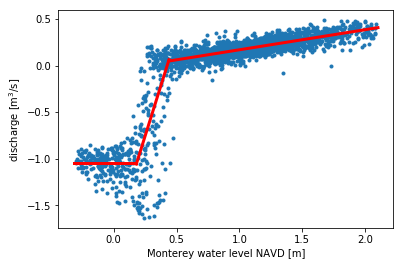

In [6]:
ipos = (d['hocn']+0.043 > 0.44) \
        & (np.isfinite(d['hocn']+d['Q']))
lrp = stats.linregress(d['hocn'][ipos]+0.043,d['Q'][ipos])

imid = (d['hocn']+0.043 <= 0.44) \
        & (d['hocn']+0.043 >= 0.18) \
        & (np.isfinite(d['hocn']+d['Q']))
lrm = stats.linregress(d['hocn'][imid]+0.043,d['Q'][imid])

ineg = (d['hocn']+0.043 <= 0.18) & (np.isfinite(d['hocn']+d['Q']))
mn = np.nanmean(d['Q'][ineg])

print('water level > 0.44 m:')
print('slope = ',str(lrp[0])[0:5])
print('intercept = ',str(lrp[1])[0:6])
print('-----------------------------')
print('0.18 < water level <= 0.44 m:')
print('slope = ',str(lrm[0])[0:5])
print('intercept = ',str(lrm[1])[0:6])
print('-----------------------------')
print('water level < 0.18 m:')
print('mean value = ',str(mn)[0:6])

plt.figure()
plt.plot(d['hocn']+0.043,d['Q'],'.')
xpos = np.array([0.44,np.nanmax(d['hocn']+0.043)])
xmid = np.array([0.18,0.44])
xneg = np.array([np.nanmin(d['hocn']+0.043),0.18])
plt.plot(xpos,lrp[0]*xpos+lrp[1],'r-',lw=3)
plt.plot(xmid,lrm[0]*xmid+lrm[1],'r-',lw=3)
plt.plot(xneg,mn*np.ones(np.shape(xneg)),'r-',lw=3)
plt.xlabel('Monterey water level NAVD [m]')
plt.ylabel('discharge [m$^3$/s]')
plt.savefig('MontereyWaterLevel_MoroCojoQ.pdf')

Develop model equations based on the relationship between $Q$ and $\Delta h$

* $Q$ - flow in and out of MC (m$^3$/s, positive into MC)
* $\Delta h$ - water level difference between MC and Monterey Bay

For comparison, the inflow is compared to theoretical flow through a 1 ft$^2$ submerged rectangular orifice. 

$Q = C_d A \sqrt{2g\Delta h}$

where $C_d$ = 0.61 is an empirically determined constant (uncertain)

based on USDA water measurement manual https://www.usbr.gov/tsc/techreferences/mands/wmm

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


Text(0, 0.5, 'discharge')

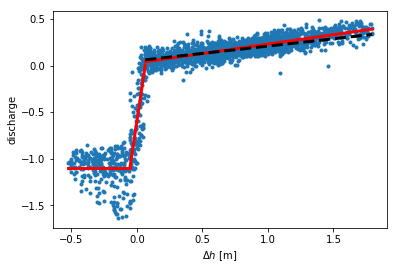

In [7]:
ipos = (d['hocn']-d['h']+0.75 > 0.065) \
        & (np.isfinite(d['hocn']+d['h']+d['Q']))
lrp = stats.linregress(d['hocn'][ipos]-d['h'][ipos]+0.75,d['Q'][ipos])

imid = (d['hocn']-d['h']+0.75 <= 0.065) \
        & (d['hocn']-d['h']+0.75 >= -0.05) \
        & (np.isfinite(d['hocn']+d['h']+d['Q']))
lrm = stats.linregress(d['hocn'][imid]-d['h'][imid]+0.75,d['Q'][imid])

ineg = (d['hocn']-d['h']+0.75 <= -0.05) & (np.isfinite(d['hocn']+d['h']+d['Q']))
mn = np.nanmean(d['Q'][ineg])

def Q_rect_orifice(A,deltah):
    Cd = 0.61
    Q = Cd*A*np.sqrt(2*9.806*deltah)
    return Q
    
plt.figure()
plt.plot(d['hocn']-d['h']+0.75,d['Q'],'.')
xpos = np.array([0.065,np.nanmax(d['hocn']-d['h']+0.75)])
xmid = np.array([-0.05,0.065])
xneg = np.array([np.nanmin(d['hocn']-d['h']+0.75),-0.05])
plt.plot(xpos,lrp[0]*xpos+lrp[1],'r-',lw=3)
plt.plot(xmid,lrm[0]*xmid+lrm[1],'r-',lw=3)
plt.plot(xpos,Q_rect_orifice(0.09294,xpos),'k--',lw=3)
plt.plot(xneg,mn*np.ones(np.shape(xneg)),'r-',lw=3)
plt.xlabel('$\Delta h$ [m]')
plt.ylabel('discharge')

Compare water level difference $\Delta h$ with $dh/dt$

Text(0, 0.5, 'dh/dt')

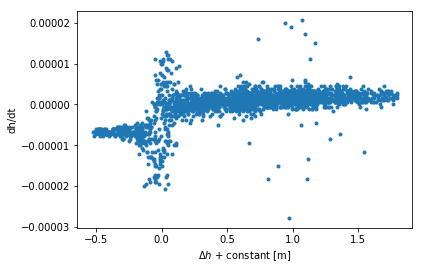

In [8]:
plt.figure()
plt.plot(d['hocn']-d['h']+0.75,d['dhdt'],'.')
plt.xlabel('$\Delta h$ + constant [m]')
plt.ylabel('dh/dt')

The area of the slough can be estimated using the equation $\frac{dh}{dt} = \frac{Q}{A}$, assuming the area of the slough does not change with water level. The estimated area based on this regression is 156546 m$^2$, or approximately 30 American football fields.

/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/Users/tomconnolly/programs/anaconda/envs/py37/lib/python3.7/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  in1zpadded[sc] = in1.copy()


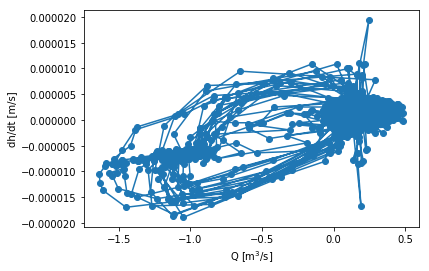

In [9]:
plt.figure()
plt.plot(d['Q'],ts.hanning(d['dhdt'],4),'-o')
plt.xlabel('Q [m$^3$/s]')
plt.ylabel('dh/dt [m/s]')
yl = plt.ylim()

Text(0.5, 1.0, 'colors = std($h_{ocn}$) - spring/neap')

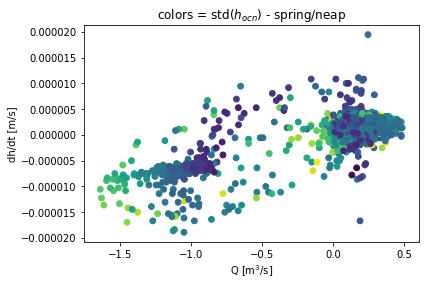

In [10]:
plt.figure()
plt.scatter(d['Q'],ts.hanning(d['dhdt'],4),s=34,c=d['h'])
plt.xlabel('Q [m$^3$/s]')
plt.ylim(yl)
plt.ylabel('dh/dt [m/s]')
plt.title('colors = std($h_{ocn}$) - spring/neap')

### Regression 

estimated area =  156546.02514001002 m^2


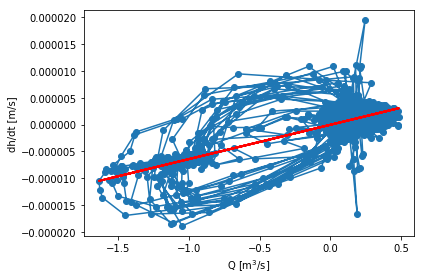

In [11]:
fi, = np.where((np.isfinite(d['Q'])) & (np.isfinite(ts.hanning(d['dhdt'],4)))) 
slope,intercept,r,p,stderr = stats.linregress(d['Q'][fi],ts.hanning(d['dhdt'],4)[fi])

# regression of y on x
slopexy,interceptxy,r,p,stderrxy = stats.linregress(ts.hanning(d['dhdt'],4)[fi],d['Q'][fi])
slope2 = 1/slopexy
intercept2 = interceptxy/slopexy

A = 1/slope
print('estimated area = ',A,'m^2')

plt.figure()
plt.plot(d['Q'],ts.hanning(d['dhdt'],4),'-o')
plt.plot(d['Q'],slope*d['Q']+intercept,'-r',lw=2)
#plt.plot(d['Q'],slope2*d['Q']+intercept2,'-r',lw=2)
plt.xlabel('Q [m$^3$/s]')
plt.ylabel('dh/dt [m/s]')
yl = plt.ylim()
plt.tight_layout()

(array([736136., 736137., 736138., 736139., 736140., 736141., 736142.,
        736143.]), <a list of 8 Text xticklabel objects>)

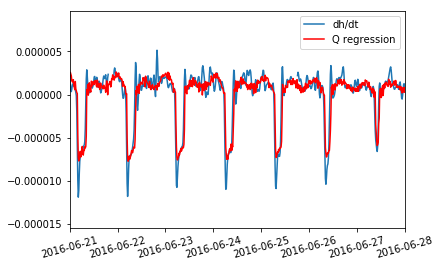

In [12]:
plt.figure()
plt.plot(d['dtime'],ts.hanning(d['dhdt'],8))
plt.plot(d['dtime'],slope*d['Q']+intercept,'r')
plt.xlim([np.datetime64('2016-06-21'),np.datetime64('2016-06-28')])
plt.legend(['dh/dt','Q regression'])
plt.xticks(rotation=15)

### Water level model



Text(0, 0.5, 'h [m]')

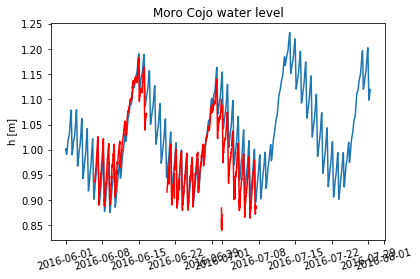

In [13]:
# time array (in seconds)
tnum = (d['dtime'].astype('datetime64[s]')-d['dtime'][0].astype('datetime64[s]'))/np.timedelta64(1,'s')
t0 = 0
tend = tnum[-1] # total time in hocn series (seconds)
t = np.arange(t0,tend,3600)

offset = 0.75

y0 = 1.0

# discharge as a function of water level difference between Monterey and M.C.
# Uses relationships from piecewise fit between water level difference and flow
def Qfunc(hdiff):
    if hdiff > 0.065:
        Qf = lrp[0]*hdiff+lrp[1]
    elif hdiff <= -0.05:
        Qf = mn
    else:
        Qf = lrm[0]*hdiff+lrm[1]
    return Qf

def dhdt(h,t,A,offset,hocn_vec,tocn_vec,lrp,lrm,mn,Qfunc):  
    # interpolate ocean height to instantaneous time
    hocn = np.interp(t,tocn_vec,hocn_vec)    
    hdiff = hocn-h+offset
    
    Qf = Qfunc(hdiff)
        
    dhdt = Qf/A
    return dhdt

hmod = odeint(dhdt, y0, tnum, args=(A,offset,d['hocn'],tnum,lrp,lrm,mn,Qfunc))

plt.figure()
plt.plot(d['dtime'],hmod)
plt.plot(d['dtime'],d['h'],'r-')
plt.xticks(rotation=15)
plt.title('Moro Cojo water level')
plt.ylabel('h [m]')

In [14]:
# hypothetical flow in tide gate failure
def Qfunc2(hdiff):
    if hdiff > 0.05:
        Qf = -mn
    elif hdiff <= -0.05:
        Qf = mn
    else:
        Qf = (-mn/0.05)*hdiff
    return Qf

hmod2,info = odeint(dhdt, y0, tnum, args=(A,offset,d['hocn'],tnum,lrp,lrm,mn,Qfunc2),tcrit=tnum,full_output=True)

#### Hypothetical gate failure

Allowing the same amount of flow to come into the slough as out. This raises the mean water level, and shifts the timing of the highest water levels to spring tides.

An important caveat is that this calculation assumes that the area of the slough does not change as water level rises. This is highly doubtful since we have seen segmentation of the slough and parts of the slough are presumably flushed at very high tides. More data from winter might be able to show nonlinearity in $dh/dt$ vs. $Q$.

A more realistic equation would be based on flow through an orifice, in which flow depends on the _square root_ of the pressure difference across the orifice.

Text(0, 0.5, 'h [m]')

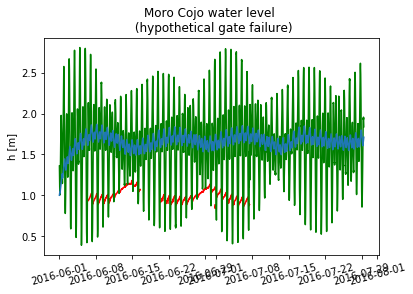

In [15]:
plt.figure()
plt.plot(d['dtime'],d['h'],'r')
plt.plot(d['dtime'],d['hocn']+offset,'g-')
plt.plot(d['dtime'],hmod2)
plt.xticks(rotation=15)
plt.title('Moro Cojo water level \n (hypothetical gate failure)')
plt.ylabel('h [m]')